# Periodgram Smoothing

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [56]:
#pip freeze > requirements.txt

# Primer boludeo con AR(1) para ganar feeling

In [57]:
""" total_points = 3000

A = 0.7
den = [1, -A]
num = [1]
ar_sys = signal.TransferFunction(num, den, dt = 1)

mean = 0
std = 1
e = np.random.normal(mean, std, total_points)

tout, yout = signal.dlsim(ar_sys, e)

plt.plot(tout, yout, linestyle='-', color='b')
plt.plot(tout, e, linestyle='-', color='r')
plt.title('Gaussian Random Sequence Over Time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.show()
 """


" total_points = 3000\n\nA = 0.7\nden = [1, -A]\nnum = [1]\nar_sys = signal.TransferFunction(num, den, dt = 1)\n\nmean = 0\nstd = 1\ne = np.random.normal(mean, std, total_points)\n\ntout, yout = signal.dlsim(ar_sys, e)\n\nplt.plot(tout, yout, linestyle='-', color='b')\nplt.plot(tout, e, linestyle='-', color='r')\nplt.title('Gaussian Random Sequence Over Time')\nplt.xlabel('Time')\nplt.ylabel('Value')\nplt.grid(True)\nplt.show()\n "

In [58]:
""" corr = np.correlate(yout[:, 0], yout[:, 0], mode = 'full')
ryy_biased = corr / total_points
ryy_unbiased_normalized = np.array([corr[x] / (total_points - np.abs(total_points-1 - x)) for x in range(0, len(corr))]) /  ryy_biased[total_points-1]
ryy_biased_normalized = ryy_biased /  ryy_biased[total_points-1]
n = np.arange(0, total_points+1)
ryy_teo = pow(A, n)

plt.plot(np.arange(-(total_points-1), total_points), ryy_biased_normalized, linestyle='-', color='b')
#plt.plot(np.arange(-(total_points-1), total_points), ryy_unbiased_normalized, linestyle='-', color='g')
plt.plot(n, ryy_teo, linestyle='-', color='r')
plt.title('biased vs teorico AR(1)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.xlim(-150, 150)
plt.show() """

" corr = np.correlate(yout[:, 0], yout[:, 0], mode = 'full')\nryy_biased = corr / total_points\nryy_unbiased_normalized = np.array([corr[x] / (total_points - np.abs(total_points-1 - x)) for x in range(0, len(corr))]) /  ryy_biased[total_points-1]\nryy_biased_normalized = ryy_biased /  ryy_biased[total_points-1]\nn = np.arange(0, total_points+1)\nryy_teo = pow(A, n)\n\nplt.plot(np.arange(-(total_points-1), total_points), ryy_biased_normalized, linestyle='-', color='b')\n#plt.plot(np.arange(-(total_points-1), total_points), ryy_unbiased_normalized, linestyle='-', color='g')\nplt.plot(n, ryy_teo, linestyle='-', color='r')\nplt.title('biased vs teorico AR(1)')\nplt.xlabel('Time')\nplt.ylabel('Value')\nplt.grid(True)\nplt.xlim(-150, 150)\nplt.show() "

In [59]:
""" plt.plot(np.arange(-(total_points-1), total_points), ryy_biased_normalized, linestyle='-', color='b')
plt.plot(np.arange(-(total_points-1), total_points), ryy_unbiased_normalized, linestyle='-', color='g')
plt.title('biased vs unbiased')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.xlim(1500, 3000)
plt.show() """

" plt.plot(np.arange(-(total_points-1), total_points), ryy_biased_normalized, linestyle='-', color='b')\nplt.plot(np.arange(-(total_points-1), total_points), ryy_unbiased_normalized, linestyle='-', color='g')\nplt.title('biased vs unbiased')\nplt.xlabel('Time')\nplt.ylabel('Value')\nplt.grid(True)\nplt.xlim(1500, 3000)\nplt.show() "

# Listo con el boludeo
----


# Periodogram classic

In [60]:
from scipy import fft

def periodogram(x):
    w = fft.fftfreq(len(x), d=1.0) * 2 * np.pi
    periodogram = np.abs(fft.fft(x))**(2) / len(x) 
    return periodogram, w


In [61]:
def biased_autocorr(x): 
    corr = np.correlate(x, x, mode = 'full')
    rxx_biased = corr / len(x)
    return rxx_biased

def unbiased_autocorr(x):
    corr = np.correlate(x, x, mode = 'full')
    rxx_unbiased = np.array([corr[n] / (len(x) - np.abs(len(x) - 1 - n)) for n in range(0, len(corr))])
    return rxx_unbiased    

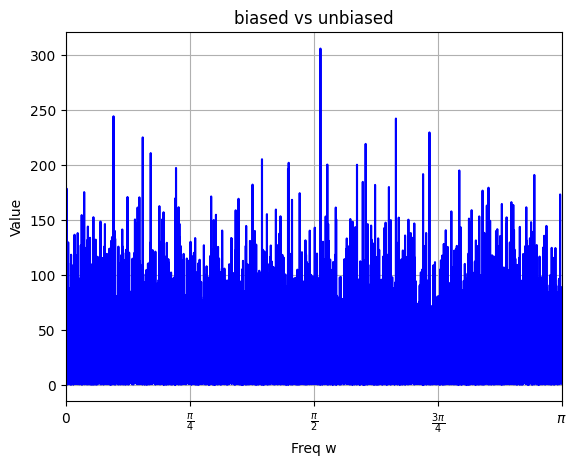

In [62]:
mean = 0
std = 5
noise = np.random.normal(mean, std, 50000) # Ruido blanco gaussiano

p, w = periodogram(noise)

plt.plot(w, p, linestyle='-', color='b')
plt.title('biased vs unbiased')
plt.xlabel('Freq w')
plt.ylabel('Value')
pi_ticks = np.arange(-np.pi, np.pi + 0.1, np.pi/4)
pi_labels = [r'$-\pi$', r'$-\frac{3\pi}{4}$', r'$-\frac{3\pi}{2}$',r'$-\frac{\pi}{4}$', '0', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$',r'$\frac{3\pi}{4}$', r'$\pi$']
plt.xticks(pi_ticks, pi_labels)
plt.xlim(0, np.pi)
plt.grid(True)
plt.show()

25.174995663813085
25.204946065621463


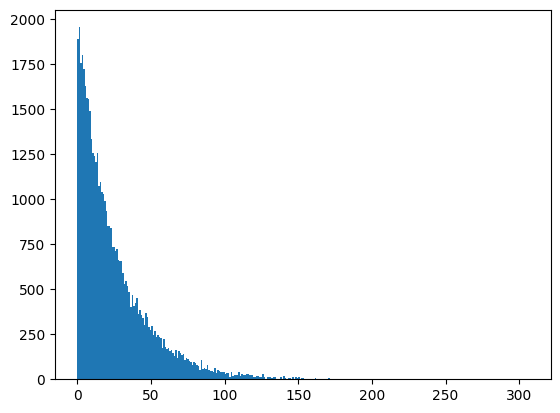

In [63]:
plt.hist(p, bins = 300)
print(np.std(p))
print(np.mean(p))

**NOTAR QUE EL STD DA LO MISMO QUE LO QUE DICE LA TEORIA, AUNQUE NO ES UNA GAUSSIANA**
---
Ahora veamos la performance del biased y unbiased

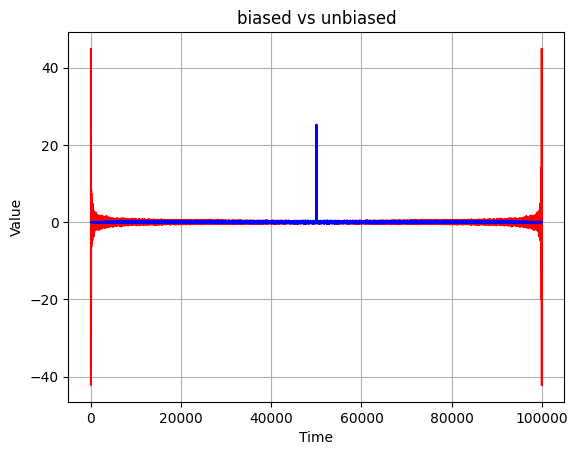

In [64]:
x = biased_autocorr(noise)
y = unbiased_autocorr(noise)
plt.plot(y, linestyle='-', color='r')
plt.plot(x, linestyle='-', color='b')
plt.title('biased vs unbiased')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.show()

**Notar el efecto del ruido amplicado**

# Periodogram Smoothing

In [65]:
# x: datos de tamaño N
# L: Siendo (L-1) tamaño del lag máximo de autocorrelación i.e. Rxx(l > |L-1|) = 0
# N_FFT: La cantidad de puntos que se usa en la FFT para visualizar el periodograma. Notar que en clase solemos hacerlo con N, pero podemos
# usar un valor mas chico a N para no hacerlo tan pesado al plot, aunque siempre debe ser mas grande que 2L-1 claramente. 
# Elegir N_FFT != N no "cambia" nada, simplemente se interpola con menos puntos
def periodogram_smoothing(x, L, N_FFT):
    N = len(x)
    rxx = biased_autocorr(x) # 2N - 1 de largo
    offset = N - 1 
    rxx = rxx[offset - (L-1) : offset + (L-1) + 1] # autocorr ventaneada o windowed con L
    window = signal.get_window(window="bartlett", Nx=2*L-1, fftbins= False) 
    rxx_windowed = rxx*window

    Rxx = np.abs(fft.fft(rxx_windowed, n = N_FFT)) # (*) ver MARKDOWN ABAJO
    w = fft.fftfreq(N_FFT, d=1.0) * 2 * np.pi
    return Rxx, w


(*) No deberia ser necesario aplicar abs, dado que siempre es positiva la ventana triangular o la de parzen, pero dado que contiene componentes imaginarias el abs debera ser aplicado. La DTFT sobre la triangular no aparece complejos, pero la DFT se puede pensar como un muestreo de la DTFT, pero SHIFTEADO en tiempo, (ver definicion de DFT), este shifteo en tiempo en frecuencia le agrega un fasor complejo, que no afecta el modulo, pero te mete complejos. 

50


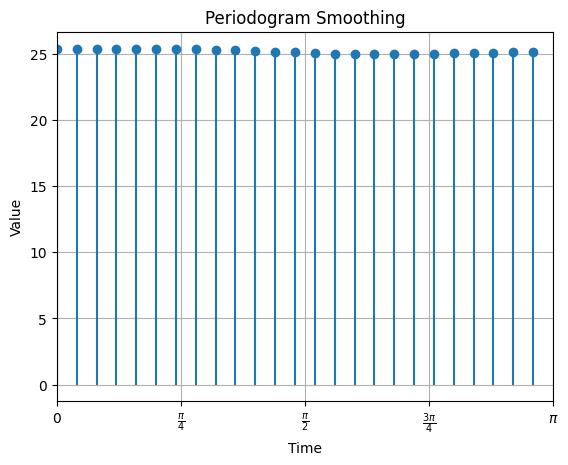

In [66]:
Rxx, w = periodogram_smoothing(noise, 5, 50)
print(len(Rxx))
# plt.plot(rxx)
# plt.plot(window)
plt.stem(w, Rxx,basefmt=" ")
plt.title('Periodogram Smoothing')

pi_ticks = np.arange(-np.pi, np.pi + 0.1, np.pi/4)
pi_labels = [r'$-\pi$', r'$-\frac{3\pi}{4}$', r'$-\frac{3\pi}{2}$',r'$-\frac{\pi}{4}$', '0', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$',r'$\frac{3\pi}{4}$', r'$\pi$']
plt.xticks(pi_ticks, pi_labels)
plt.xlabel('Time')
plt.ylabel('Value')
plt.xlim(0, np.pi)
plt.grid(True)
plt.show()

In [67]:
def pulse(n, M):
    return np.array([1 if (np.abs(nVal) <= (M-1)/2) else 0 for nVal in n])

# Periodogram Averaging

In [68]:
def periodogram_averaging(x, L, D, N_FFT): # procurar que N_FFT > 2L-1
    N = len(x)
    num_segmentos = (N - L)//D      # Cantidad de segmentos con largo L
    Rx = np.zeros(N_FFT)
    for i in range(0, num_segmentos):
        x_seg = x[i*D : i*D + L]
        Rx += 1/L * np.abs(fft.fft(x_seg, N_FFT))**2

    Rx = Rx/num_segmentos
    w = fft.fftfreq(N_FFT, d=1.0) * 2 * np.pi
    return Rx, w

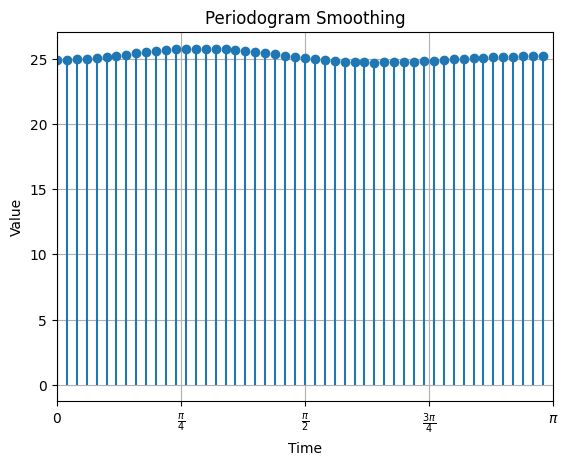

In [69]:
Rxx, w = periodogram_averaging(noise, 5, 5, 100)

plt.stem(w, Rxx,basefmt=" ")
plt.title('Periodogram Smoothing')

pi_ticks = np.arange(-np.pi, np.pi + 0.1, np.pi/4)
pi_labels = [r'$-\pi$', r'$-\frac{3\pi}{4}$', r'$-\frac{3\pi}{2}$',r'$-\frac{\pi}{4}$', '0', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$',r'$\frac{3\pi}{4}$', r'$\pi$']
plt.xticks(pi_ticks, pi_labels)

plt.xlabel('Time')
plt.ylabel('Value')
plt.xlim(0, np.pi)
plt.grid(True)
plt.show()

# DATASET L1 32 SEC 4K

In [70]:
import h5py

def dump_info(name, obj):
    print("{0} :".format(name))
    try:
        print("   .value: {0}".format(obj[()]))
        for key in obj.attrs.keys():
            print("     .attrs[{0}]:  {1}".format(key, obj.attrs[key]))
    except:
        pass

filename = 'L-L1_GWOSC_4KHZ_R1-1126259447-32.hdf5'
file = h5py.File(filename, 'r')
file.visititems(dump_info)



meta :
meta/Description :
   .value: b'Strain data time series from LIGO'
meta/DescriptionURL :
   .value: b'http://www.gw-openscience.org/'
meta/Detector :
   .value: b'L1'
meta/Duration :
   .value: 32
meta/GPSstart :
   .value: 1126259447
meta/Observatory :
   .value: b'L'
meta/Type :
   .value: b'StrainTimeSeries'
meta/UTCstart :
   .value: b'2015-09-14T09:50:30'
quality :
quality/detail :
quality/injections :
quality/injections/InjDescriptions :
   .value: [b'Passes NO_CBC_HW_INJ test' b'Passes NO_BURST_HW_INJ test'
 b'Passes NO_DETCHAR_HW_INJ test' b'Passes NO_CW_HW_INJ test'
 b'Passes NO_STOCH_HW_INJ test']
quality/injections/InjShortnames :
   .value: [b'NO_CBC_HW_INJ' b'NO_BURST_HW_INJ' b'NO_DETCHAR_HW_INJ' b'NO_CW_HW_INJ'
 b'NO_STOCH_HW_INJ']
quality/injections/Injmask :
   .value: [23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23
 23 23 23 23 23 23 23 23]
     .attrs[Bits]:  5
     .attrs[Description]:  A bitmask encoded as an integer-valued timeseries

In [71]:
dset = file['strain/Strain'][()]
fs = 1 / file['strain/Strain'].attrs['Xspacing']
print(fs)

4096.0


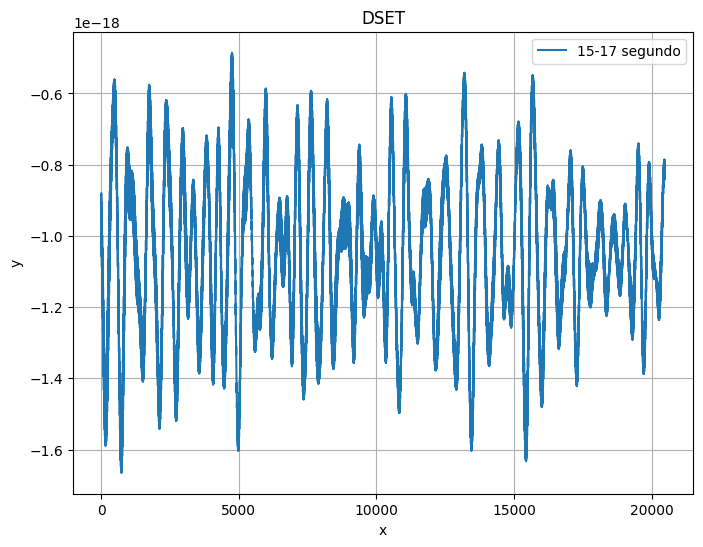

In [128]:
plt.figure(figsize=(8, 6))
plt.plot(dset[int(0*fs): int(5*fs)], label='15-17 segundo')
plt.title('DSET')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()


Evento es considerado que ocurre entre 14 y 20 segundos

255


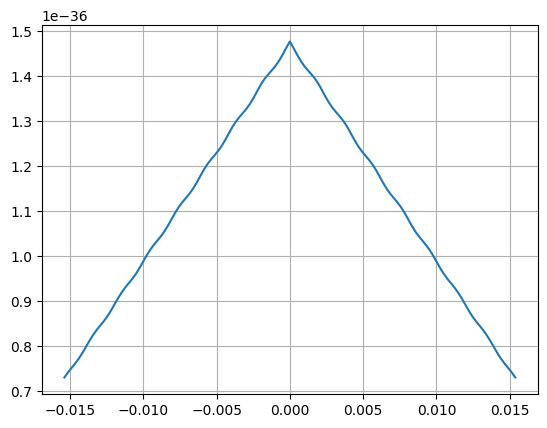

In [79]:
noise1 = dset[:int(14*fs)]
noise2 = dset[int(20*fs):int(32*fs)-1]
L = 16
N = L*8
L_2 = L*4
offset = N - 1 
rxx = biased_autocorr(noise1[:N])
print(len(rxx))
rxx = rxx[offset - (L_2-1) : offset + (L_2-1) + 1] # autocorr ventaneada o windowed con L
lags = np.arange(-(L_2-1), (L_2-1) + 1) / fs
plt.plot(lags, rxx)
plt.grid(True)
plt.show()
# plt.figure()

255


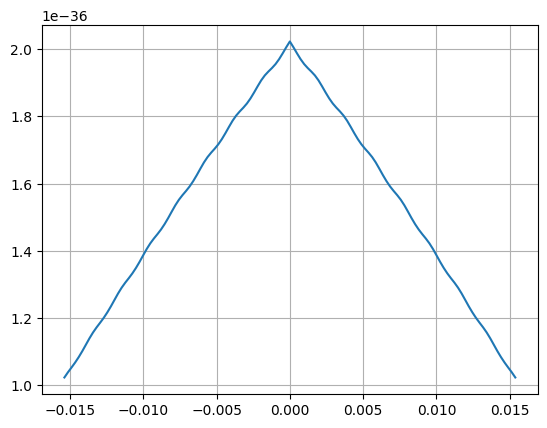

In [84]:
noise1 = dset[:int(14*fs)]
noise2 = dset[int(20*fs):int(32*fs)-1]

L = 16
N = L*8
L_2 = L*4
offset = N - 1 
rxx = biased_autocorr(noise1[N:2*N])
print(len(rxx))
rxx = rxx[offset - (L_2-1) : offset + (L_2-1) + 1] # autocorr ventaneada o windowed con L
lags = np.arange(-(L_2-1), (L_2-1) + 1) / fs
plt.plot(lags, rxx)
plt.grid(True)
plt.show()
# plt.figure()

255


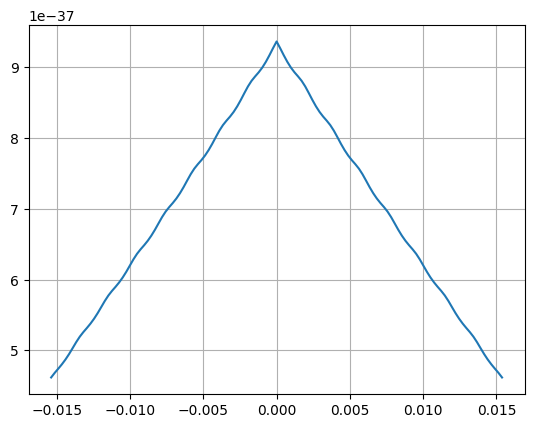

In [87]:
noise1 = dset[:int(14*fs)]
noise2 = dset[int(20*fs):int(32*fs)-1]

L = 16
N = L*8
L_2 = L*4
offset = N - 1 
rxx = biased_autocorr(noise1[2*N:3*N])
print(len(rxx))
rxx = rxx[offset - (L_2-1) : offset + (L_2-1) + 1] # autocorr ventaneada o windowed con L
lags = np.arange(-(L_2-1), (L_2-1) + 1) / fs
plt.plot(lags, rxx)
plt.grid(True)
plt.show()
# plt.figure()

15999


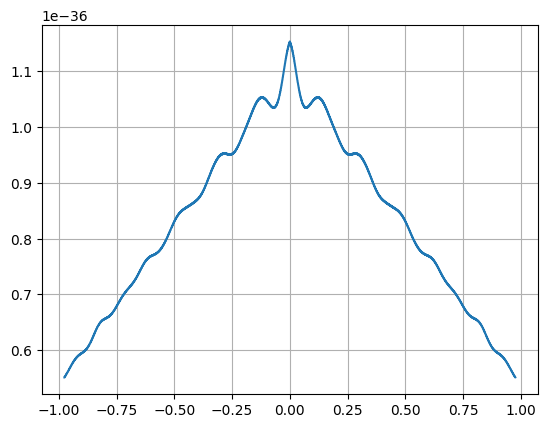

In [140]:
noise1 = dset[:int(14*fs)]
noise2 = dset[int(20*fs):int(32*fs)-1]

L = 1000
N = L*8
L_2 = L*4
offset = N - 1 
rxx = biased_autocorr(noise1[0:N])
rxx = np.mean(np.asarray([biased_autocorr(noise1[i*N:(i+1)*N]) for i in range(len(noise1)//N)]), axis=0)
print(len(rxx))
rxx = rxx[offset - (L_2-1) : offset + (L_2-1) + 1] # autocorr ventaneada o windowed con L
lags = np.arange(-(L_2-1), (L_2-1) + 1) / fs
plt.plot(lags, rxx)
plt.grid(True)
plt.show()
# plt.figure()

In [133]:
np.mean(np.asarray([biased_autocorr(noise1[i*N:(i+1)*N]) for i in range(len(noise1)//N)]), axis=0).shape

# len([biased_autocorr(noise1[i*N:(i+1)*N]) for i in range(len(noise1)//N)])

(31999,)

In [131]:
np.asarray([biased_autocorr(noise1[i*N:(i+1)*N]) for i in range(len(noise1)//N)])

(3, 31999)